# BlueEarth Data: working with Zarr data

Notebook contains several example of converting sea level rise exposure data from multiple NetCDF files to one Zarr file


In [1]:
# Optional; code formatter, installed as jupyter lab extension
#%load_ext lab_black
# Optional; code formatter, installed as jupyter notebook extension
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
# imports
import os
import pathlib
import sys
import platform
import xarray as xr
import pandas as pd
import zarr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# make root directories importable by appending root to path
cwd = pathlib.Path().resolve()
sys.path.append(os.path.dirname(cwd))

# OS independent path configurations
if platform.system() == "Windows":
    root = pathlib.Path("C:/")
else:  # linux or other
    root = pathlib.Path("/p/")
# root = pathlib.Path().home().root
slr_impact_data_dir = pathlib.Path(root, "Users", "twigt_d", "Downloads", "_temp")

## Write Sea Level Rise impact dataset to Zarr

In [3]:
# Extreme Sea Level (JRC) paths for example how to migrate netcdf to zarr
slr_rcp26_present_path = slr_impact_data_dir.joinpath("Population_exposed_SLR=SSP1-2.6_CONF=Medium_POP=Present_RP=100.nc")
slr_rcp26_SSP1_path = slr_impact_data_dir.joinpath("Population_exposed_SLR=SSP1-2.6_CONF=Medium_POP=SSP1_RP=100.nc")
slr_rcp45_present_path = slr_impact_data_dir.joinpath("Population_exposed_SLR=SSP2-4.5_CONF=Medium_POP=Present_RP=100.nc")
slr_rcp45_SSP1_path = slr_impact_data_dir.joinpath("Population_exposed_SLR=SSP2-4.5_CONF=Medium_POP=SSP2_RP=100.nc")
slr_rcp85_present_path = slr_impact_data_dir.joinpath("Population_exposed_SLR=SSP5-8.5_CONF=Medium_POP=Present_RP=100.nc")
slr_rcp85_SSP1_path = slr_impact_data_dir.joinpath("Population_exposed_SLR=SSP5-8.5_CONF=Medium_POP=SSP5_RP=100.nc")

slr_rcp26_present = xr.open_dataset(slr_rcp26_present_path)
slr_rcp26_SSP1 = xr.open_dataset(slr_rcp26_SSP1_path)
slr_rcp45_present = xr.open_dataset(slr_rcp45_present_path)
slr_rcp45_SSP1 = xr.open_dataset(slr_rcp45_SSP1_path)
slr_rcp85_present = xr.open_dataset(slr_rcp85_present_path)
slr_rcp85_SSP1 = xr.open_dataset(slr_rcp85_SSP1_path)


<IPython.core.display.Javascript object>

In [4]:
slr_rcp26_present

<xarray.Dataset>
Dimensions:      (Region: 58, Year: 131, Percentile: 3)
Coordinates:
  * Region       (Region) object 'GIC' 'NWN' 'NEN' 'WNA' ... 'EIO' 'SIO' 'SOO'
  * Year         (Year) int64 2020 2021 2022 2023 2024 ... 2147 2148 2149 2150
  * Percentile   (Percentile) int64 17 50 83
    SLR          object ...
    Confidence   object ...
    Population   object ...
    Flooding     int32 ...
Data variables:
    Pop_exposed  (Region, Year, Percentile) float64 ...

<IPython.core.display.Javascript object>

In [110]:
# concat datasets along new dimension with index values and name derived from pandas index object
slr_present = xr.concat(
    [slr_rcp26_present, slr_rcp45_present, slr_rcp85_present],
    pd.Index(["rcp26", "rcp45", "rcp85"], name="Scenario"),
)

<IPython.core.display.Javascript object>

In [111]:
# concat datasets along new dimension with index values and name derived from pandas index object
slr_SSP1 = xr.concat(
    [slr_rcp26_SSP1, slr_rcp45_SSP1, slr_rcp85_SSP1],
    pd.Index(["rcp26", "rcp45", "rcp85"], name="Scenario"),
)

<IPython.core.display.Javascript object>

In [112]:
slr = xr.concat(
    [slr_present, slr_SSP1],
    pd.Index(["present", "SSP1"], name="Population"),
)

<IPython.core.display.Javascript object>

In [113]:
# rename dimension names and re-order shape of data variables
# eessl = slr_SSP1.rename_dims({"row": "stations", "col": "rp"})
slr = slr.transpose("Scenario", "Population", "Region", "Year", "Percentile")



<IPython.core.display.Javascript object>

In [114]:
# scenario is in bold because the coordinate is a dimension index (maybe this should be changed..)
slr

<xarray.Dataset>
Dimensions:      (Region: 58, Year: 131, Percentile: 3, Scenario: 3,
                  Population: 2)
Coordinates:
  * Region       (Region) object 'GIC' 'NWN' 'NEN' 'WNA' ... 'EIO' 'SIO' 'SOO'
  * Year         (Year) int64 2020 2021 2022 2023 2024 ... 2147 2148 2149 2150
  * Percentile   (Percentile) int64 17 50 83
    SLR          (Scenario) <U8 'SSP1-2.6' 'SSP2-4.5' 'SSP5-8.5'
    Confidence   <U6 'Medium'
  * Population   (Population) object 'present' 'SSP1'
    Flooding     int32 100
  * Scenario     (Scenario) object 'rcp26' 'rcp45' 'rcp85'
Data variables:
    Pop_exposed  (Scenario, Population, Region, Year, Percentile) float64 0.0...

<IPython.core.display.Javascript object>

In [115]:
# export to zarr in write mode (to overwrite iff exists)
slr.to_zarr(slr_impact_data_dir.joinpath("Population_exposed.zarr"), mode="w")

<IPython.core.display.Javascript object>

In [116]:
# local stored zarr
slr_check = xr.open_dataset(slr_impact_data_dir.joinpath("Population_exposed.zarr"))

C:\Users\twigt_d\Anaconda3\lib\site-packages\xarray\backends\plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
C:\Users\twigt_d\Anaconda3\lib\site-packages\xarray\backends\plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<IPython.core.display.Javascript object>

Text(0, 0.5, 'Population exposed')

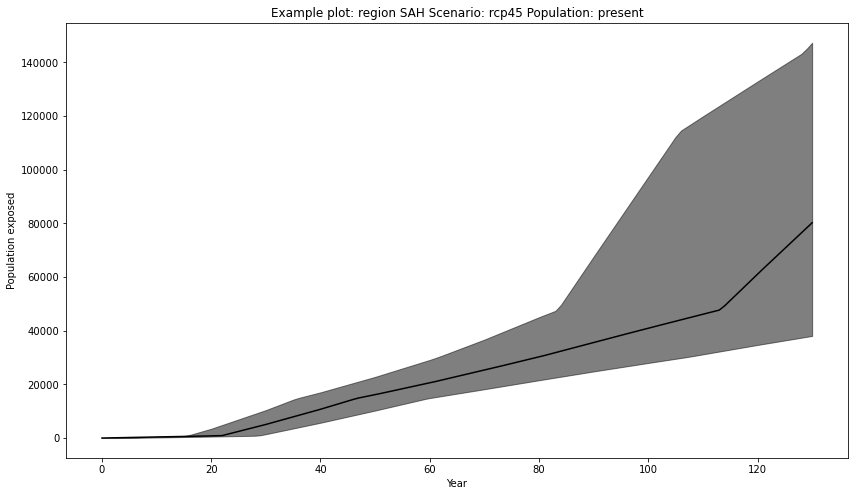

<IPython.core.display.Javascript object>

In [123]:
# slr_check.isel(Region=1, Percentile=0, scenario=0, population=0)["Pop_exposed"].plot()

region_id = 20
scenario_id = 1
population_id = 0

lb = slr_check.isel(
    Region=region_id, Percentile=0, Scenario=scenario_id, Population=population_id
)["Pop_exposed"]
mean = slr_check.isel(
    Region=region_id, Percentile=1, Scenario=scenario_id, Population=0
)["Pop_exposed"]
ub = slr_check.isel(
    Region=region_id, Percentile=2, Scenario=scenario_id, Population=population_id
)["Pop_exposed"]

fig = plt.figure(1, figsize=(14, 8))
plt.fill_between(range(mean.shape[0]), ub, lb, color="k", alpha=0.5)
plt.plot(mean, "k")
plt.title(
    "Example plot: region "
    + str(slr_check.Region[region_id].values)
    + " Scenario: "
    + str(slr_check.Scenario[scenario_id].values)
    + " Population: "
    + str(slr_check.Population[population_id].values)
)
plt.xlabel("Year")
plt.ylabel("Population exposed")

In [4]:
# cloud stored zarr with zarr

g = zarr.open_group(
    "gs://dgds-data-public/data/Population_exposed.zarr",
    storage_options={"anon": True},
)

g.info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.FSStore
No. members,9
No. arrays,9
No. groups,0
Arrays,"Confidence, Flooding, Percentile, Pop_exposed, Population, Region, SLR, Scenario, Year"


In [5]:
# cloud stored zarr with xarray
ds_gcs = xr.open_dataset(
    "gs://dgds-data-public/data/Population_exposed.zarr",
    backend_kwargs={"storage_options": {"project": "coclico", "token": None}},
    engine="zarr",
)

# or

ds = xr.open_zarr("gs://dgds-data-public/data/Population_exposed.zarr")